In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob
import os

plt.rcParams['font.family'] = 'Franklin Gothic Medium'

colors = pd.read_csv('data/team_colors.csv')

champs_glob = glob.glob(os.path.join('data/champs', "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in champs_glob)
all_champs = pd.concat(df_from_each_file, ignore_index=True)

data = colors.merge(all_champs, how = "right", on = ["Team", "League"])

In [3]:
winners = data[data["Wins"] > 0]


#winners = winners.replace({"EPL": "EPL⚽",
#                           "La Liga": "La Liga⚽",
#                           "Serie A": "Serie A⚽",
#                           "NFL": "NFL🏈",
#                           "NBA": "NBA🏀",
#                           "NHL": "NHL🏒",
#                           "MLB": "MLB⚾",
#                           "NCAA": "NCAA🏈🏀"})
winners.head()

,Team,hex_Primary_Color,hex_Secondary_Color,League,wc_css2_Primary_Name,wc_css2_Secondary_Name,wc_css3_Primary_Name,wc_css3_Secondary_Name,wa_Primary_Names,wa_Secondary_Names,wa_Primary_Name_1,wa_Primary_Name_2,wa_Secondary_Name_1,wa_Secondary_Name_2,Wins
2,Baltimore Ravens,#241773,#000000,NFL🏈,navy,black,midnightblue,black,"midnight blue,navy","black,dim gray",midnight blue,navy,black,dim gray,2
5,Chicago Bears,#0B162A,#C83803,NFL🏈,black,red,black,firebrick,"midnight blue,steel blue","orange red,chocolate",midnight blue,steel blue,orange red,chocolate,1
8,Dallas Cowboys,#041E42,#869397,NFL🏈,navy,gray,midnightblue,lightslategray,"navy,dark blue","light slate gray,slate gray",navy,dark blue,light slate gray,slate gray,5
9,Denver Broncos,#002244,#FB4F14,NFL🏈,navy,red,midnightblue,orangered,"navy,teal","orange red,chocolate",navy,teal,orange red,chocolate,3
11,Green Bay Packers,#203731,#FFB612,NFL🏈,black,orange,darkslategray,orange,"dark slate gray,cadet blue","orange,dark orange",dark slate gray,cadet blue,orange,dark orange,4


For plotting, let's create dictionaries that map each named color to their hex value. This will make plotting much easier in the future. We can functionalize this:

In [4]:
def make_color_dict(color_name_header):
    if "Primary" in color_name_header: 
        colors = "hex_Primary_Color"
    else:
        colors = "hex_Secondary_Color"
        
    color_dict = pd.Series(winners[colors].values, index = winners[color_name_header]).to_dict()
    return color_dict
    
webcolors_css2_p = make_color_dict("wc_css2_Primary_Name")
webcolors_css2_s = make_color_dict("wc_css2_Secondary_Name")
webcolors_css3_p = make_color_dict("wc_css3_Primary_Name")
webcolors_css3_s = make_color_dict("wc_css3_Secondary_Name")

wolfram_p_1 = make_color_dict("wa_Primary_Name_1")
wolfram_p_2 = make_color_dict("wa_Primary_Name_2")
wolfram_s_1 = make_color_dict("wa_Secondary_Name_1")
wolfram_s_2 = make_color_dict("wa_Secondary_Name_2")

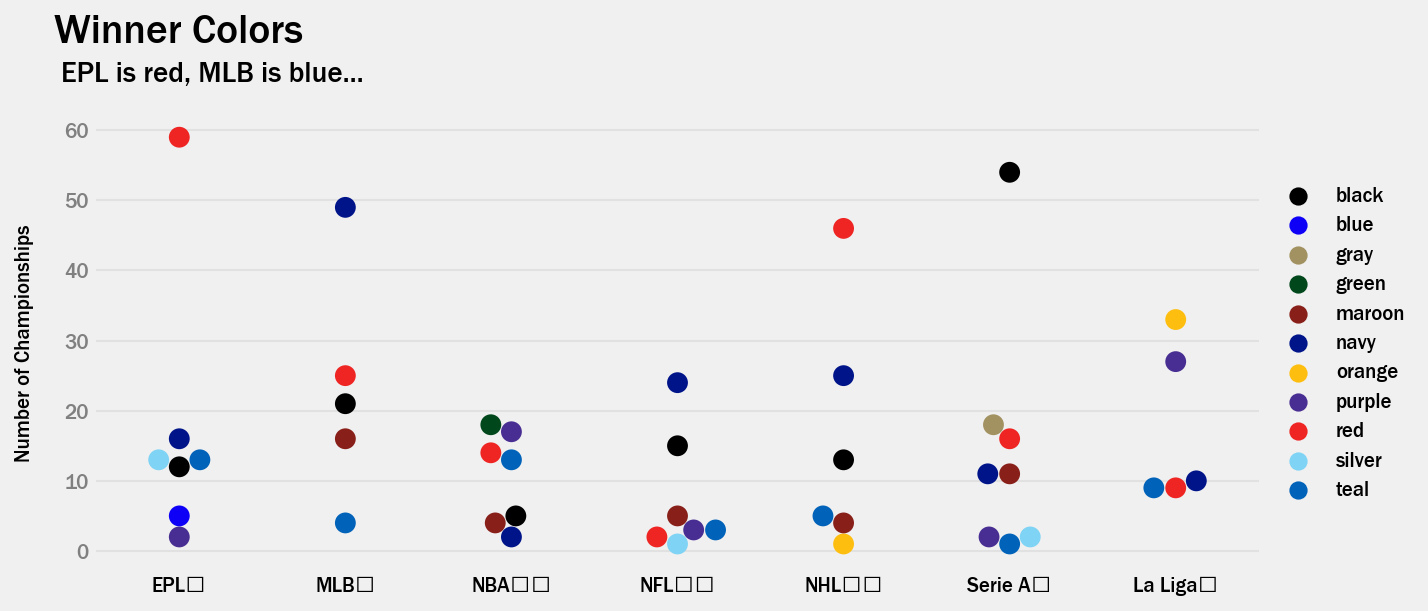

In [9]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

g = sns.swarmplot(data = winners.groupby(["wc_css2_Primary_Name", "League"])["Wins"].sum().reset_index(),
                  x="League", y="Wins",
                  hue="wc_css2_Primary_Name",
                  palette=webcolors_css2_p,
                  size = 10)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.suptitle('Winner Colors', x=0.18, y=1.05, fontsize=20)
plt.title('EPL is red, MLB is blue...', x=0.1, y=1.05, fontsize=14)
plt.xlabel("")
plt.ylabel("Number of Championships\n")
plt.yticks(color="gray")
plt.tick_params(length=0)

#for tick in ax.get_xticklabels(): tick.set_fontname("Segoe UI Emoji")

fig.set_facecolor("#F0F0F0")
ax.set_facecolor("#F0F0F0")

sns.despine(left=True, bottom=True)
g.grid(b=True, which='major', axis="y", color='lightgray', linewidth=1.0, alpha=0.5)

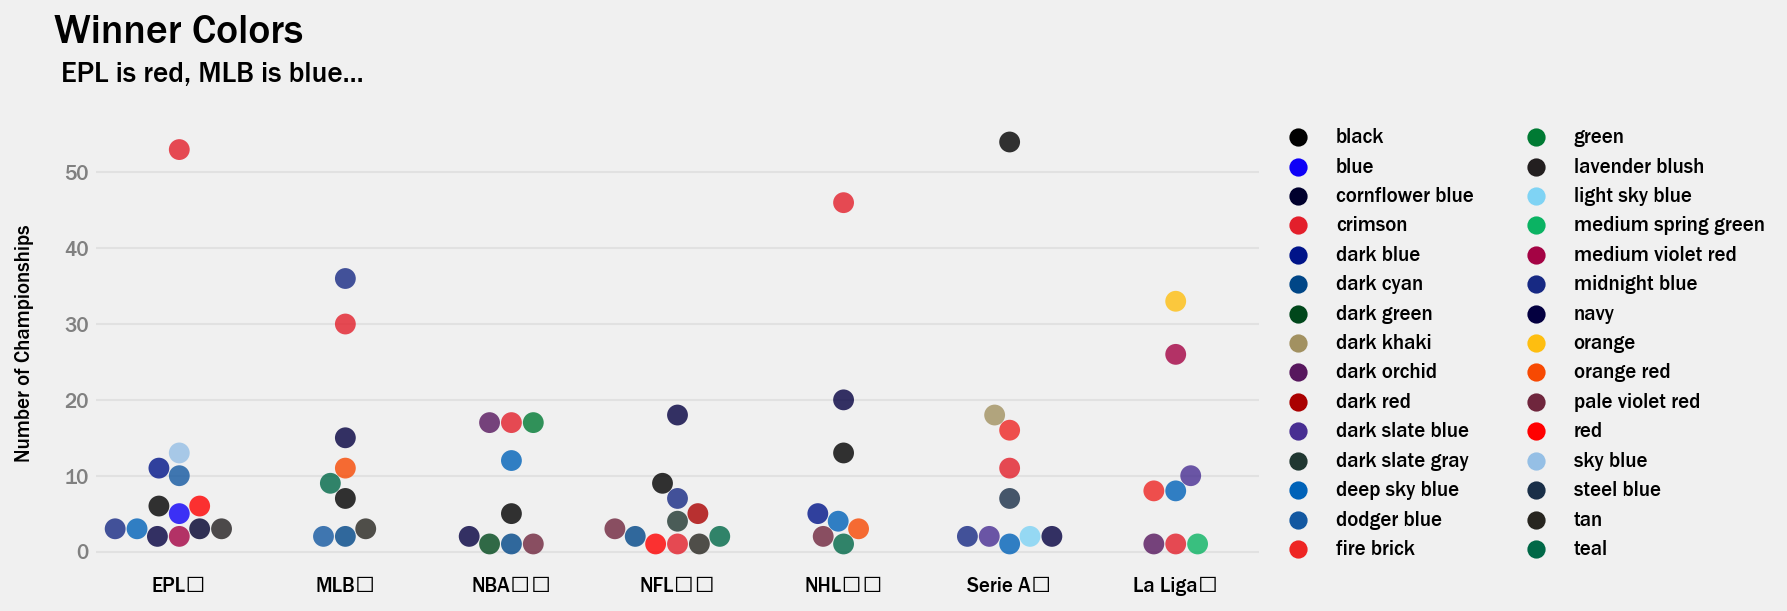

In [11]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

g = sns.swarmplot(data = winners.groupby(["wa_Primary_Name_1", "League"])["Wins"].sum().reset_index(),
                  x="League", y="Wins",
                  hue="wa_Primary_Name_1", 
                  palette=wolfram_p_1,
                  size = 10,
                  alpha = 0.8)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, ncol=2)

plt.suptitle('Winner Colors', x=0.18, y=1.05, fontsize=20)
plt.title('EPL is red, MLB is blue...', x=0.1, y=1.05, fontsize=14)
plt.xlabel("")
plt.ylabel("Number of Championships\n")
plt.yticks(color="gray")
plt.tick_params(length=0)

#for tick in ax.get_xticklabels(): tick.set_fontname("Segoe UI Emoji")

fig.set_facecolor("#F0F0F0")
ax.set_facecolor("#F0F0F0")

sns.despine(left=True, bottom=True)
g.grid(b=True, which='major', axis="y", color='lightgray', linewidth=1.0, alpha=0.5)

# TOP 20 PRIMARY COLORS PLOT

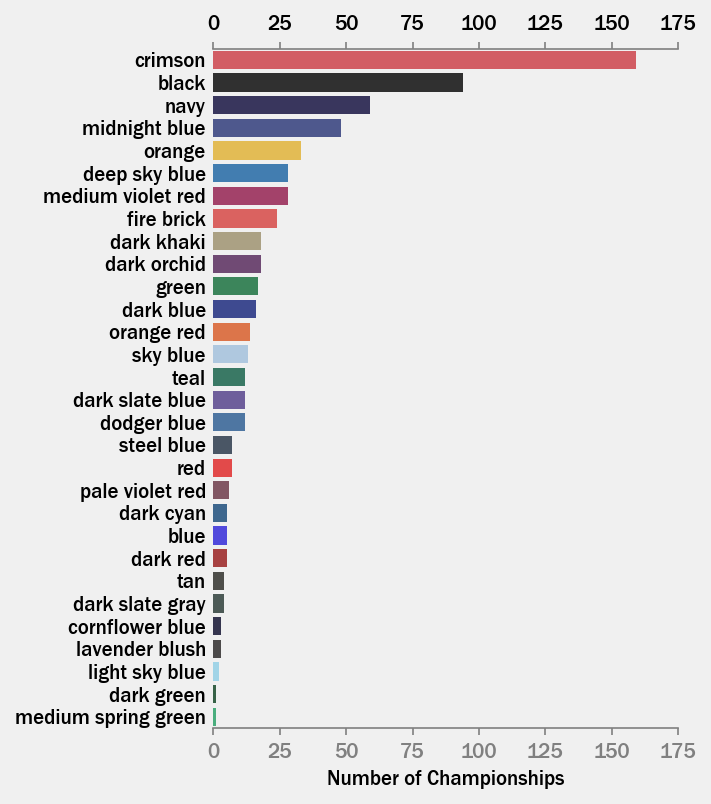

In [167]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

g = sns.barplot(data = winners.groupby(["wa_Primary_Name_1"])["Wins"].
                       sum().
                       reset_index().
                       sort_values(by = ["Wins"], ascending=False),
                x = "Wins", y = "wa_Primary_Name_1",
                hue = "wa_Primary_Name_1", palette = wolfram_p_1, alpha=0.8, dodge=False)

plt.ylabel("")
plt.xlabel("Number of Championships")
plt.xlim(0, 175)

fig.set_facecolor("#F0F0F0")
ax.set_facecolor("#F0F0F0")
sns.despine(left=True, top=False)
plt.tick_params(axis="y", length=0)
plt.xticks(color="gray")
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')

g.legend_.remove()
g.tick_params(labelbottom=True, labeltop=True, top=True, color="gray")

# TOP 20 SECONDARY COLORS

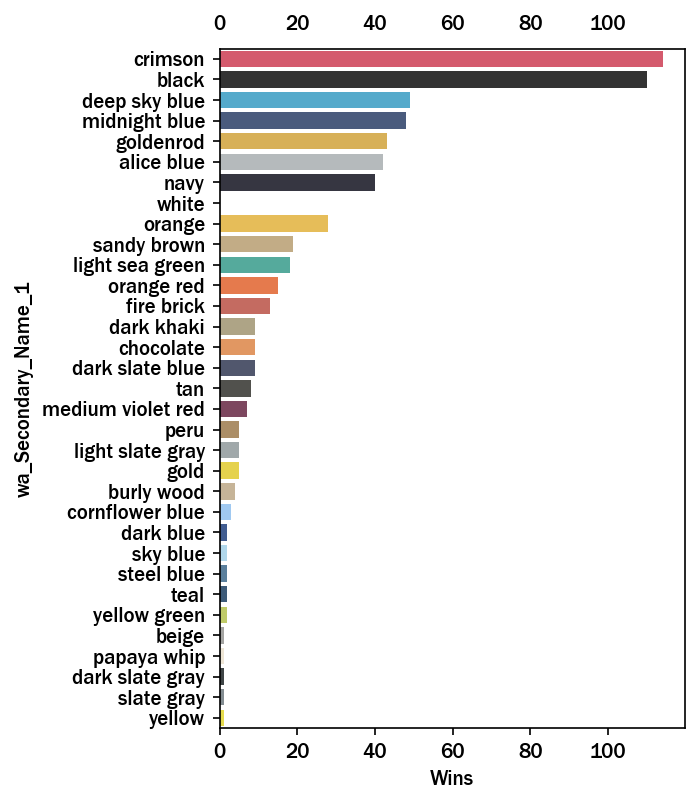

In [11]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

g = sns.barplot(data = winners.groupby(["wa_Secondary_Name_1"])["Wins"].
                       sum().
                       reset_index().
                       sort_values(by = ["Wins"], ascending=False),
                x = "Wins", y = "wa_Secondary_Name_1",
                hue = "wa_Secondary_Name_1", palette = wolfram_s_1, alpha=0.8, dodge=False)

g.legend_.remove()
g.tick_params(labelbottom=True, labeltop=True)

# Get Frequency and plot

In [189]:
temp = data.groupby(["wa_Secondary_Name_1", "League"])["Wins"].agg("sum").reset_index()
temp.head()

,wa_Secondary_Name_1,League,Wins
0,alice blue,MLB,30
1,alice blue,NBA,6
2,alice blue,NFL,4
3,alice blue,NHL,2
4,beige,NHL,1


Text(0.5, 1.05, 'Championships per color')

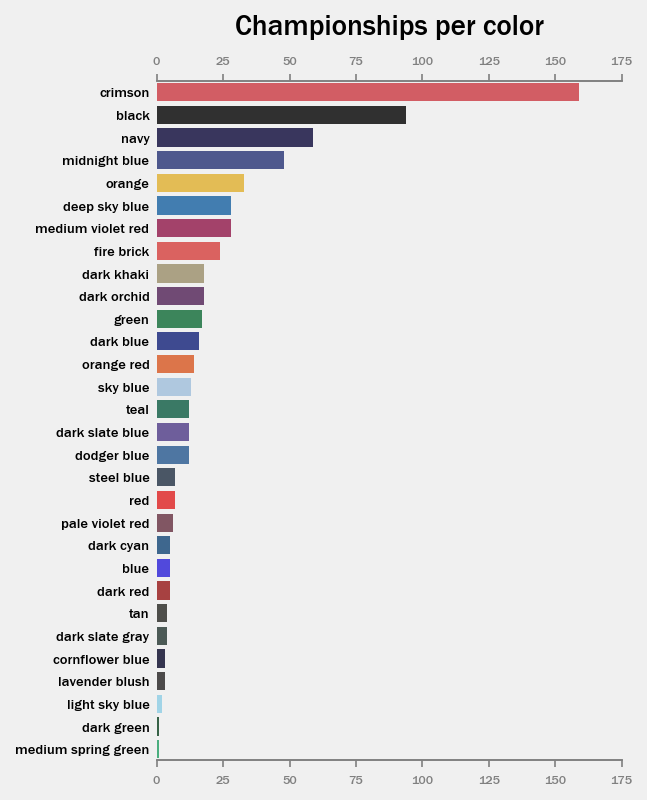

In [54]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

g = sns.barplot(data = winners.groupby(["wa_Primary_Name_1"])["Wins"].
                       sum().
                       reset_index().
                       sort_values(by = ["Wins"], ascending=False),
                x = "Wins", y = "wa_Primary_Name_1",
                hue = "wa_Primary_Name_1", palette = wolfram_p_1, alpha=0.8, dodge=False)

plt.ylabel("")
plt.xlabel("")
plt.xlim(0, 175)

fig.set_facecolor("#F0F0F0")
ax.set_facecolor("#F0F0F0")
plt.tick_params(axis="y", length=0)
plt.xticks(color="gray", size=6)
plt.yticks(size = 7)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')

axT = ax.twiny()
#axT.set_xlim(ax.get_xlim())
axT.set_xlim(0, 175)
import matplotlib.ticker as ticker
axT.xaxis.set_major_locator(ticker.MultipleLocator(25))



g.legend_.remove()
g.tick_params(color="gray")
axT.tick_params(color="gray", labelsize=6)

axT.tick_params(axis='x', colors="gray")

sns.despine(left=True, top=False)

#ax.spines['bottom'].set_color('gray')
axT.spines['top'].set_color('gray')
axT.spines['bottom'].set_color("gray")

#plt.suptitle('Championships per color', x=0.18, y=1.05, fontsize=20)
plt.title('Championships per color', x=0.5, y=1.05, fontsize=14)


In [9]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['C:\\Windows\\Fonts\\impact.ttf',
 'C:\\WINDOWS\\Fonts\\ebrima.ttf',
 'C:\\Windows\\Fonts\\CALIST.TTF',
 'C:\\Windows\\Fonts\\BOD_R.TTF',
 'C:\\WINDOWS\\Fonts\\GILI____.TTF',
 'C:\\WINDOWS\\Fonts\\mvboli.ttf',
 'C:\\WINDOWS\\Fonts\\TCB_____.TTF',
 'C:\\Windows\\Fonts\\constan.ttf',
 'C:\\Windows\\Fonts\\tahomabd.ttf',
 'C:\\WINDOWS\\Fonts\\BOD_CB.TTF',
 'C:\\WINDOWS\\Fonts\\DUBAI-MEDIUM.TTF',
 'C:\\Windows\\Fonts\\comicbd.ttf',
 'C:\\WINDOWS\\Fonts\\GILLUBCD.TTF',
 'C:\\Windows\\Fonts\\cambriab.ttf',
 'C:\\Windows\\Fonts\\SCHLBKB.TTF',
 'C:\\Windows\\Fonts\\SitkaI.ttc',
 'C:\\Windows\\Fonts\\seguibl.ttf',
 'C:\\WINDOWS\\Fonts\\GILB____.TTF',
 'C:\\WINDOWS\\Fonts\\georgia.ttf',
 'C:\\Windows\\Fonts\\framd.ttf',
 'C:\\WINDOWS\\Fonts\\CENSCBK.TTF',
 'C:\\Windows\\Fonts\\Sitka.ttc',
 'C:\\WINDOWS\\Fonts\\CENTURY.TTF',
 'C:\\WINDOWS\\Fonts\\LTYPEB.TTF',
 'C:\\WINDOWS\\Fonts\\BASKVILL.TTF',
 'C:\\WINDOWS\\Fonts\\pala.ttf',
 'C:\\WINDOWS\\Fonts\\tahoma.ttf',
 'C:\\Windows\\Fonts\\ANTQUAI.TTF